In [2]:
from IPython.display import Markdown, display_pdf
from rich.markdown import Markdown as rich_Markdown
import time
from typing import List, Dict
from tqdm import tqdm
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama.llms import OllamaLLM

import utils_rag as ur


In [3]:
import os

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [4]:
import json 

def cargar_json(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
        datos = json.load(archivo)
    return datos

# Ejemplo de uso
ruta_archivo = 'data/chunks_docs/dict_pdfs.json'
dict_pdfs = cargar_json(ruta_archivo)
print(dict_pdfs)

{'file1': {'file_path': 'data/docs/DT_Golondrinas.pdf', 'output_path': 'data/chunks_docs/chunks_DT_Golondrinas.json'}, 'file2': {'file_path': 'data/docs/Implementacion-y-aplicaciones-de-un-sistema-de-codificacion-automatica-de-la-lista-de-espera-chilena.pdf', 'output_path': 'data/chunks_docs/chunks_Implementacion-y-aplicaciones-de-un-sistema-de-codificacion-automatica-de-la-lista-de-espera-chilena.json'}, 'file3': {'file_path': 'data/docs/DeepSeek_R1.pdf', 'output_path': 'data/chunks_docs/chunks_DeepSeek_R1.json'}}


In [5]:
ruta_archivo = 'data/chunks_docs/chunks_DeepSeek_R1.json'
chunks_DeepSeek_R1_json = cargar_json(ruta_archivo)

In [7]:
chunks_DeepSeek_R1 = ur.ejecutar_chunking_pdf(dict_pdfs['file3'],ejecutar_pdf=False)

In [8]:
tables, texts, images_b64 = ur.data_general(chunks_DeepSeek_R1)

In [50]:


def create_summary_chain(model="llama3.2"):
    """Create the basic summary chain components"""
    prompt_text = """
    Eres un asistente cuya tarea es resumir tablas y texto.
    Da un resumen conciso de la tabla o el texto.
    
    Responde solo con el resumen, sin comentarios adicionales.
    No comiences tu mensaje diciendo "Aquí hay un resumen" ni nada por el estilo.
    Solo da el resumen tal como está.
    
    Siempre el resumen debe ser entregado en español
    
    Fragmento de tabla o texto: {element}
    """
    
    prompt = ChatPromptTemplate.from_template(prompt_text)
    model = OllamaLLM(temperature=0.5,model=model)
    return {"element": lambda x: x} | prompt | model | StrOutputParser()

def process_texts(text_chunks: List[Dict],
                 model: str, 
                 text_key: str,
                 use_batch: bool = False,
                 max_concurrency: int = 3) -> List[Dict]:
    """
    Process text chunks either sequentially or in batches using chain.batch()
    
    Args:
        text_chunks: List of dictionaries containing text and metadata
        text_key: Key to access text content in chunks
        use_batch: If True, process using batch(); if False, process sequentially
        max_concurrency: Maximum number of concurrent requests for batch processing
    """
    summarize_chain = create_summary_chain(model)
    results = []
    
    # Extract texts for processing
    texts = [chunk[text_key] for chunk in text_chunks]
    
    try:
        if use_batch:
            # Batch processing using chain.batch()
            summaries = summarize_chain.batch(texts, {"max_concurrency": max_concurrency})
            
            # Combine results with metadata
            for i, summary in enumerate(summaries):
                results.append({
                    'summary': summary,
                    'page_number': text_chunks[i].get('page_number'),
                    'filename': text_chunks[i].get('filename'),
                    'status': 'success'
                })
        else:
            # Sequential processing
            for chunk in tqdm(text_chunks, desc="Processing sequentially"):
                try:
                    texto = chunk[text_key]
                    resumen = summarize_chain.invoke(texto)
                    results.append({
                        'summary': resumen,
                        'page_number': chunk.get('page_number'),
                        'filename': chunk.get('filename'),
                        'status': 'success'
                    })
                except Exception as e:
                    results.append({
                        'summary': None,
                        'page_number': chunk.get('page_number'),
                        'filename': chunk.get('filename'),
                        'status': f'error: {str(e)}'
                    })
                    
    except Exception as e:
        print(f"Batch processing error: {str(e)}")
        return []
        
    return results



In [51]:
text_chunks, tables_html_chunks, images_b64_chunks = ur.extract_text_with_page_mapping(chunks_DeepSeek_R1)

In [ ]:
# Batch processing
time_start = time.time()
batch_results = process_texts(text_chunks
                              ,model="llama3.2"
                              ,text_key='text'
                              ,use_batch=True
                              ,max_concurrency=3)
time_end = time.time()
time_elapsed = time_end - time_start
print(f"Batch processing time: {time_elapsed:.2f} seconds")

Batch processing time: 93.05 seconds


In [ ]:
time_start = time.time()
sequential_results_tables = process_texts(tables_html_chunks
                                          ,model="llama3.2"
                                          ,text_key='text_html'
                                          ,use_batch=True
                                          ,max_concurrency=3)
time_end = time.time()
time_elapsed = time_end - time_start
print(f"Batch processing time: {time_elapsed:.2f} seconds")

In [73]:
text_summaries=batch_results
table_summaries=sequential_results_tables

## Vector Store

In [65]:
from langchain_community.embeddings import HuggingFaceEmbeddings

In [92]:
embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

In [93]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document

from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embed_model)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [94]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in text_chunks]
summary_texts=[Document(page_content=doc_s['summary'],
           metadata={id_key: doc_ids[i]
                     ,'page_number':str(doc_s['page_number'])
                     ,'file_name':doc_s['filename']}) for i, doc_s in enumerate(text_summaries)]


retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, text_chunks)))

In [95]:

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables_html_chunks]
summary_tables = [Document(page_content=doc_s['summary'],
           metadata={id_key: doc_ids[i]
                     ,'page_number':str(doc_s['page_number'])
                     ,'file_name':doc_s['filename']}) for i, doc_s in enumerate(table_summaries)]

retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables_html_chunks)))

In [102]:
# Retrieve
docs = retriever.invoke(
    "que es deekseek?",
)

In [103]:

display(rich_Markdown(docs[0]['text'])) 

CodeForces Table 2 | Comparison of DeepSeek-R1-Zero and OpenAI o1 models on reasoning-related benchmarks. Figure 2 
| AIME accuracy of DeepSeek-R1-Zero during training. For each question, we sample 16 responses and calculate the   
overall average accuracy to ensure a stable evaluation. DeepSeek-R1-Zero to attain robust reasoning capabilities   
without the need for any supervised fine-tuning data. This is a noteworthy achievement, as it underscores the      
model’s ability to learn and generalize effectively through RL alone. Additionally, the performance of DeepSeek-   
R1-Zero can be further augmented through the application of majority voting. For example, when majority voting is  
employed on the AIME benchmark, DeepSeek-R1-Zero’s performance escalates from 71.0% to 86.7%, thereby exceeding the
performance of OpenAI-o1-0912. The ability of DeepSeek-R1-Zero to achieve such competitive performance, both with  
and without majority voting, highlights its strong foundational capabilities and its potential for further         
advancements in reasoning tasks. Self-evolution Process of DeepSeek-R1-Zero The self-evolution process of          
DeepSeek-R1-Zero is a fascinating demonstration of how RL can drive a model to improve its reasoning capabilities  
autonomously. By initiating RL directly from the base model, we can closely monitor the model’s progression without
the influence of the supervised fine-tuning stage. This approach provides a clear view of how the model evolves    
over time, particularly in terms of its ability to handle complex reasoning tasks. As depicted in Figure 3, the    
thinking time of DeepSeek-R1-Zero shows consistent improve- 7 Figure 3 | The average response length of            
DeepSeek-R1-Zero on the training set during the RL process. DeepSeek-R1-Zero naturally learns to solve reasoning   
tasks with more thinking time. ment throughout the training process. This improvement is not the result of external
adjustments but rather an intrinsic development within the model. DeepSeek-R1-Zero naturally acquires the ability  
to solve increasingly complex reasoning tasks by leveraging extended test-time compu- tation. This computation     
ranges from generating hundreds to thousands of reasoning tokens, allowing the model to explore and refine its     
thought processes in greater depth. One of the most remarkable aspects of this self-evolution is the emergence of  
sophisticated behaviors as the test-time computation increases. Behaviors such as reflection—where the model       
revisits and reevaluates its previous steps—and the exploration of alternative approaches to problem-solving arise 
spontaneously. These behaviors are not explicitly programmed but instead emerge as a result of the model’s         
interaction with the reinforcement learning environment. This spontaneous development significantly enhances       
DeepSeek-R1-Zero’s reasoning capabilities, enabling it to tackle more challenging tasks with greater efficiency and
accuracy. Aha Moment of DeepSeek-R1-Zero A particularly intriguing phenomenon observed during the training of      
DeepSeek-R1-Zero is the occurrence of an “aha moment”. This moment, as illustrated in Table 3, occurs in an        
intermediate version of the model. During this phase, DeepSeek-R1-Zero learns to allocate more thinking time to a  
problem by reevaluating its initial approach. This behavior is not only a testament to the model’s growing         
reasoning abilities but also a captivating example of how reinforcement learning can lead to unexpected and        
sophisticated outcomes. This moment is not only an “aha moment” for the model but also for the researchers         
observing its behavior. It underscores the power and beauty of reinforcement learning: rather than explicitly      
teaching the model on how to solve a problem, we simply provide it with the right incentives, and it autonomously  
develops advanced problem-solving strategies. The “aha m

# RAG 

In [107]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaLLM
import base64
from PIL import Image
import io

def resize_base64_image(base64_string, size=(128,128)):
    """Redimensiona una imagen en base64"""
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))
    resized_img = img.resize(size, Image.LANCZOS)
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def parse_chunks(chunks):
    """Separa los chunks en texto, tablas e imágenes"""
    texts = []
    tables = [] 
    images = []
    
    for chunk in chunks:
        if 'text' in chunk:
            texts.append(chunk)
        if 'text_html' in chunk:
            tables.append(chunk)
        if 'images_b64' in chunk:
            # Redimensionar imagen antes de agregarla
            resized_img = resize_base64_image(chunk['images_b64'])
            images.append(resized_img)
            
    return {
        "texts": texts,
        "tables": tables, 
        "images": images
    }

def build_prompt(kwargs):
    """Construye el prompt con el contexto y la pregunta"""
    chunks_by_type = kwargs["context"]
    query = kwargs["question"]
    
    context = ""
    
    # Agregar textos al contexto
    if chunks_by_type["texts"]:
        context += "\nTextos:\n"
        for text in chunks_by_type["texts"]:
            context += f"{text['text']}\n"
            
    # Agregar tablas al contexto    
    if chunks_by_type["tables"]:
        context += "\nTablas:\n"
        for table in chunks_by_type["tables"]:
            context += f"{table['text_html']}\n"

    prompt_template = f"""
    Responde la pregunta basándote únicamente en el siguiente contexto que incluye texto, tablas e imágenes.
    
    Contexto: {context}
    
    Pregunta: {query}
    """
    
    prompt_content = [{"type": "text", "text": prompt_template}]
    
    # Agregar imágenes al prompt
    if chunks_by_type["images"]:
        for image in chunks_by_type["images"]:
            prompt_content.append({
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"}
            })
            
    return ChatPromptTemplate.from_messages([
        HumanMessage(content=prompt_content)
    ])

# Definir el modelo
model = OllamaLLM(model="llama3.2")

# Construir el chain
chain = (
    {
        "context": RunnableLambda(parse_chunks),
        "question": RunnablePassthrough()
    }
    | RunnableLambda(build_prompt)
    | model 
    | StrOutputParser()
)

# Chain con fuentes
chain_with_sources = {
    "context": RunnableLambda(parse_chunks),
    "question": RunnablePassthrough()
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser() 
    )
)

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Base components
def parse_docs(docs):
    """Split base64-encoded images and texts"""
    texts = []
    tables = []
    images = []
    
    for doc in docs:
        if 'text' in doc:
            texts.append(doc)
        if 'text_html' in doc:
            tables.append(doc) 
        if 'images_b64' in doc:
            images.append(doc)
    return {
        "texts": texts,
        "tables": tables,
        "images": images
    }

def build_prompt(kwargs):
    """Build prompt with context and source citations"""
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]
    
    # Build context text with citations
    context_text = ""
    if docs_by_type["texts"]:
        for text in docs_by_type["texts"]:
            context_text += f"\nTexto (página {text['page_number']}): {text['text']}\n"
            
    if docs_by_type["tables"]:
        for table in docs_by_type["tables"]:
            context_text += f"\nTabla (página {table['page_number']}): {table['text_html']}\n"

    # Construct prompt with citations instruction
    prompt_template = f"""
    Responde la pregunta basándote únicamente en el siguiente contexto.
    Incluye las páginas de donde obtuviste la información al final de la respuesta 
    usando el formato: [Fuente: página X].
    
    Contexto: {context_text}
    
    Pregunta: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if docs_by_type["images"]:
        for image in docs_by_type["images"]:
            prompt_content.append({
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            })

    return ChatPromptTemplate.from_messages([
        HumanMessage(content=prompt_content),
    ])


# Chain definition
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | OllamaLLM(model="llama3.2")
    | StrOutputParser()
)

# Chain with sources 
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | OllamaLLM(model="llama3.2")
        | StrOutputParser()
    )
)

In [114]:
response = chain_with_sources.invoke(
    "que es deepseek?"
)

print(response)

{'context': {'texts': [{'text': '1.2. Summary of Evaluation Results\n• Reasoning tasks: (1) DeepSeek-R1 achieves a score of 79.8% Pass@1 on AIME 2024, slightly surpassing OpenAI-o1-1217. On MATH-500, it attains an impressive score of 97.3%, performing on par with OpenAI-o1-1217 and significantly outperforming other models. (2) On coding-related tasks, DeepSeek-R1 demonstrates expert level in code competition tasks, as it achieves 2,029 Elo rating on Codeforces outperforming 96.3% human participants in the competition. For engineering-related tasks, DeepSeek-R1 performs slightly better than DeepSeek-V3, which could help developers in real world tasks.\n• Knowledge: On benchmarks such as MMLU, MMLU-Pro, and GPQA Diamond, DeepSeek- R1 achieves outstanding results, significantly outperforming DeepSeek-V3 with scores of 90.8% on MMLU, 84.0% on MMLU-Pro, and 71.5% on GPQA Diamond. While its performance is slightly below that of OpenAI-o1-1217 on these benchmarks, DeepSeek-R1 surpasses other 

In [120]:
response['response']

'El modelo DeepSeek se refiere al modelo de inteligencia artificial desarrollado para resolver problemas de razonamiento y comprensión del lenguaje. El modelo utiliza técnicas de aprendizaje profundo y de reforzamiento para mejorar su capacidad de razonamiento y solución de problemas.\n\nDe acuerdo con el texto proporcionado, DeepSeek-R1 es una versión mejorada del modelo original, que utiliza técnicas de aprendizaje profundo y reforzamiento para mejorar su capacidad de razonamiento. Esta versión ha demostrado ser capaz de resolver problemas complejos de razonamiento y comprensión del lenguaje de manera autónoma.\n\nDeepSeek-R1-Zero es una versión aún más avanzada del modelo, que utiliza técnicas de aprendizaje profundo y reforzamiento para mejorar su capacidad de razonamiento. Esta versión ha demostrado ser capaz de resolver problemas complejos de razonamiento y comprensión del lenguaje de manera autónoma, y ha desarrollado comportamientos innovadores y sofisticados en el proceso.\n\n

In [126]:
response

{'context': {'texts': [{'text': '1.2. Summary of Evaluation Results\n• Reasoning tasks: (1) DeepSeek-R1 achieves a score of 79.8% Pass@1 on AIME 2024, slightly surpassing OpenAI-o1-1217. On MATH-500, it attains an impressive score of 97.3%, performing on par with OpenAI-o1-1217 and significantly outperforming other models. (2) On coding-related tasks, DeepSeek-R1 demonstrates expert level in code competition tasks, as it achieves 2,029 Elo rating on Codeforces outperforming 96.3% human participants in the competition. For engineering-related tasks, DeepSeek-R1 performs slightly better than DeepSeek-V3, which could help developers in real world tasks.\n• Knowledge: On benchmarks such as MMLU, MMLU-Pro, and GPQA Diamond, DeepSeek- R1 achieves outstanding results, significantly outperforming DeepSeek-V3 with scores of 90.8% on MMLU, 84.0% on MMLU-Pro, and 71.5% on GPQA Diamond. While its performance is slightly below that of OpenAI-o1-1217 on these benchmarks, DeepSeek-R1 surpasses other 

# Borrar

In [ ]:
# Sequential processing
"""
time_start = time.time()
sequential_results = process_texts(text_chunks
                                   ,model="llama3.2"
                                   ,text_key='text'
                                   ,use_batch=False)
time_end = time.time()
time_elapsed = time_end - time_start
print(f"Sequential processing time: {time_elapsed:.2f} seconds")

"""

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt_text = """
Eres un asistente cuya tarea es resumir tablas y texto.
Da un resumen conciso de la tabla o el texto.

Responde solo con el resumen, sin comentarios adicionales.
No comiences tu mensaje diciendo "Aquí hay un resumen" ni nada por el estilo.
Solo da el resumen tal como está.

Siempre el resumen debe ser entregado en español

Fragmento de tabla o texto: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
#model = OllamaLLM(temperature=0.5, model="llama3.2")
model = OllamaLLM(model="deepseek-r1:8b")

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()


In [ ]:
def summarize_text_chunks(text_chunks,text):
    """
    Aplica la cadena de resumen a cada fragmento de texto.
    
    Args:
        text_chunks (List[Dict]): Lista de diccionarios con 'text' y 'page_number'.
    
    Returns:
        List[Dict]: Lista de diccionarios con 'summary' y 'page_number'.
    """
    summarized_chunks = []
    
    for chunk in text_chunks:
        texto = chunk[text]
        paginas = chunk['page_number']
        
        # Crear el contexto para el prompt, incluyendo las páginas
        prompt_input = f"{texto}"
        
        # Aplicar la cadena de resumen
        resumen = summarize_chain.invoke(prompt_input)
        
        summarized_chunks.append({
            'summary': resumen,
            'page_number': paginas
        })
    
    return summarized_chunks

In [ ]:
# Usage example
if __name__ == "__main__":
    test_chunks = [
        {'text': 'Sample text 1', 'page_number': 1},
        {'text': 'Sample text 2', 'page_number': 2}
    ]
    # Sequential processing
    sequential_results = process_texts(test_chunks,model="llama3.2", text_key='text', use_batch=False)
    # Batch processing
    batch_results = process_texts(test_chunks,model="llama3.2", text_key='text', use_batch=True, batch_size=2)

In [15]:
ejemplo = [chunks_DeepSeek_R1[0],chunks_DeepSeek_R1[1]]
text_chunks, tables_html_chunks, images_b64_chunks = ur.extract_text_with_page_mapping(ejemplo)

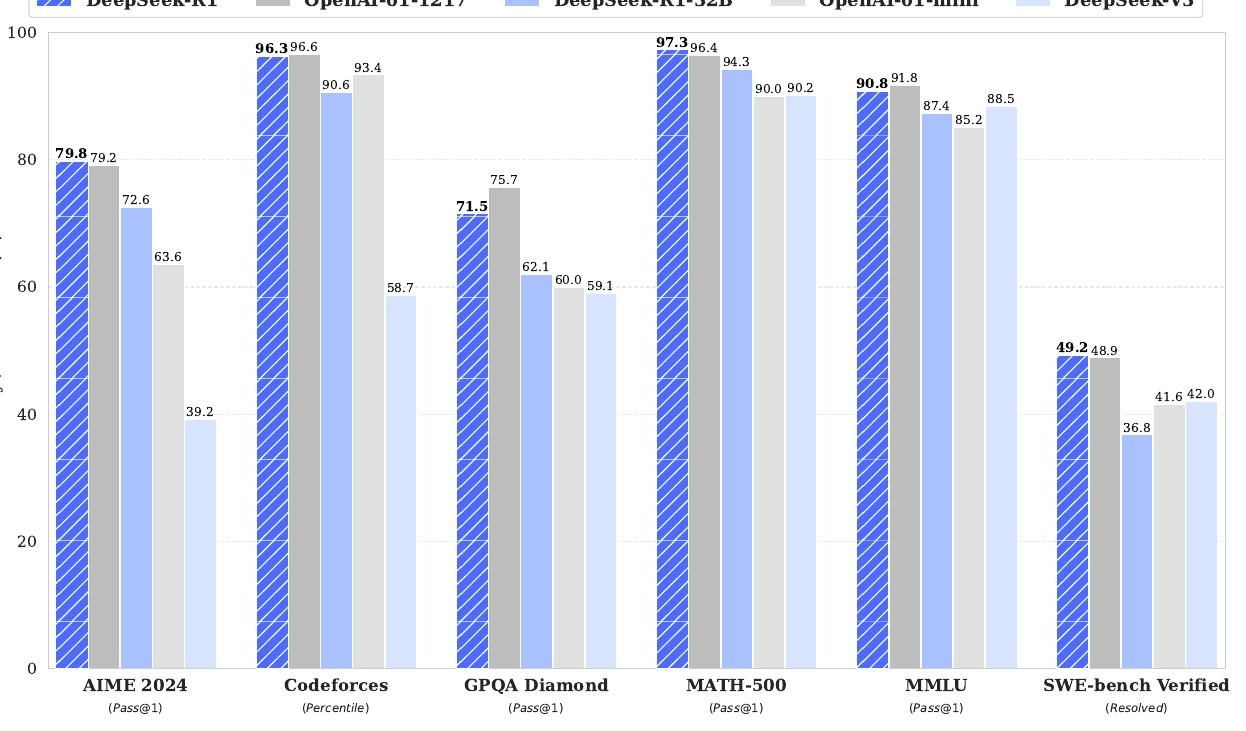

In [16]:
ur.display_base64_image(images_b64_chunks[1]['images_b64'])

In [17]:
# Aplicar la función de resumen
summaries = summarize_text_chunks(text_chunks,'text')

Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')trace=c7e1c850-9323-47fe-9ac2-81489381b77a,id=c7e1c850-9323-47fe-9ac2-81489381b77a; trace=c7e1c850-9323-47fe-9ac2-81489381b77a,id=a4840027-2d41-43a4-9e61-6a8134812a91; trace=c7e1c850-9323-47fe-9ac2-81489381b77a,id=d7f9269f-5555-4616-b0ec-071cea9cdd0e; trace=c7e1c850-9323-47fe-9ac2-81489381b77a,id=c7e5b964-1efe-45fd-a756-86d45016aeb4; trace=c7e1c850-9323-47fe-9ac2-81489381b77a,id=6752c142-2588-4622-bc40-5f5cbf574ac0
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail"

In [18]:
summaries_tables = summarize_text_chunks(tables_html_chunks,'text_html')

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
Failed to send compressed multipart i

In [19]:

display(rich_Markdown(summaries_tables[0]['summary'])) 

Okay, so I need to make sense of this. Maybe the table is summarizing some kind of research project or presentation
where different methods are being evaluated. The abbreviations suggest it's related to machine learning techniques,
possibly in NLP or another AI field. "Reinforcement Learning" definitely sounds like a key area here.              

First, I should probably parse the headers and see what they're indicating. It seems like there are several        
sections: ".1 Deep?eeE-Rl Evaluation," ".2 Distilled Model," and then some other parts that might be subsections or
additional experiments.                                                                                            

Looking at the rows under these headers, I notice mentions of "Distillation" vs. something else, possibly another  
method like "Fine-Tuning." There are also sections about the effectiveness of small models with reasoning          
capabilities.                                                                                                      

I'm trying to figure out if this table is comparing different approaches or outcomes in a study. Maybe they're     
testing how well certain models perform under various conditions or tasks.                                         

One thing that stands out is the use of symbols like "=" and "-", which might indicate equality or lack thereof    
between different methods. For example, "L1: Distillation vs ..." could be indicating that one method              
(Distillation) is being compared against another.                                                                  

The abbreviations are a bit tricky, but I think they're shorthand for specific techniques or methodologies within  
the field of AI/ML. It's possible that "Empower Small Models with Reasoning Capability" refers to training smaller 
models that still possess logical reasoning abilities, which is a big deal because typically, more powerful models 
are needed for complex tasks.                                                                                      

I also notice mentions of "Limitations and Future Work," suggesting that while the research has made progress,     
there are areas that need improvement or further exploration. This is common in academic papers where they outline 
what their work lacks and where others could build upon it.                                                        

Another part says "Discussion: Reinforcement," which might be a section discussing how reinforcement learning plays
into these methods. It's also possible that the table includes information about experiments conducted, like how   
many were successful or what parameters were tweaked.                                                              

But honestly, without more context, it's hard to piece together exactly what each part means. Maybe I'm            
overcomplicating it. If this is from a presentation, perhaps it's a summary slide that's meant to give an overview 
of the study's structure and key findings without going into too much detail.                                      

I should also consider that some parts might be typos or formatting issues since there are question marks like     
"Ur\successfu" which might be a misplaced character. Correcting those could help in understanding the content      
better.                                                                                                            

Overall, I think breaking down each section and trying to associate them with common methodologies would be a good 
approach. Maybe looking up terms like "Distillation," "Reinforcement Learning," and "Empower Small Models"         
individually could provide more clarity on what's being discussed here.                                            

It might also help to look at the structure of similar tables or slides from other sources to see how they organize
their information. Understanding the formatti

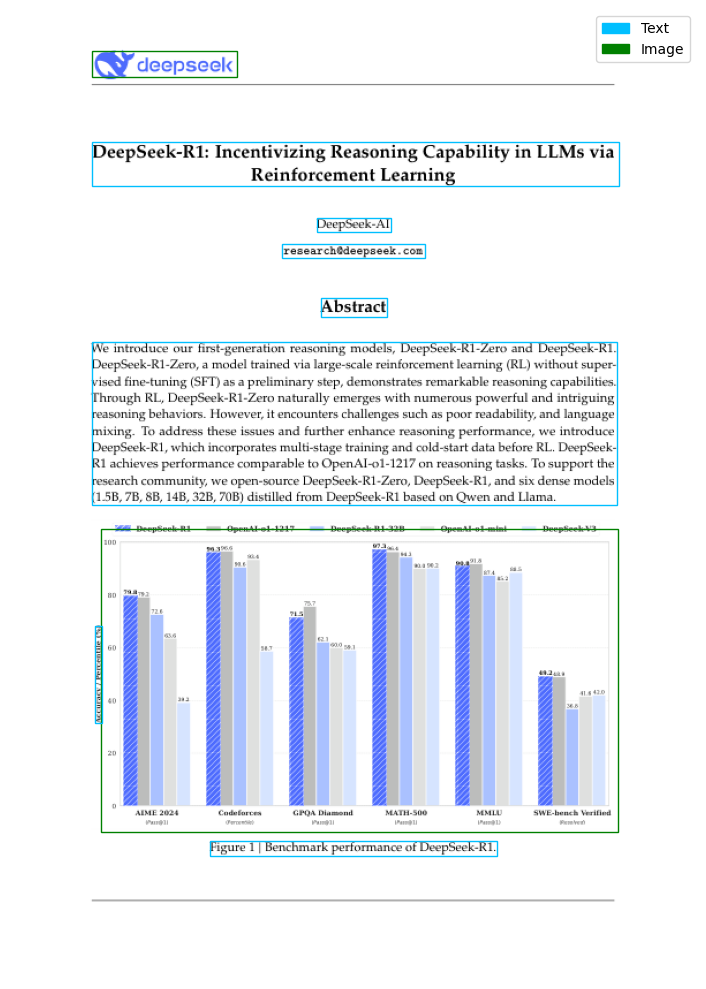

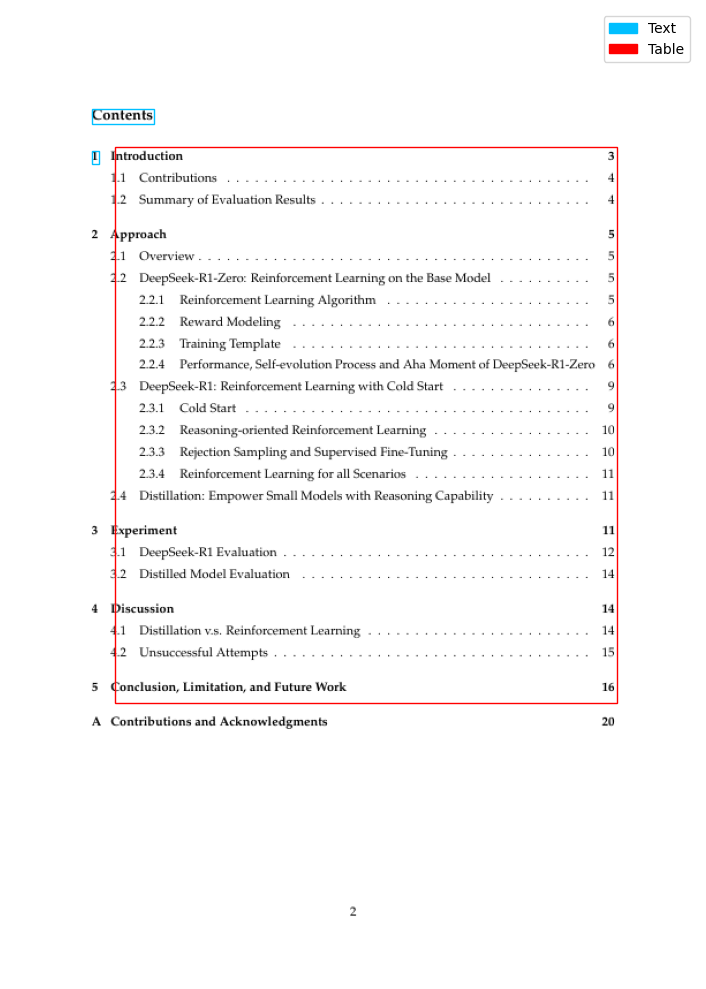

In [20]:
ur.display_chunk_pages(chunks_DeepSeek_R1[0],dict_pdfs['file3']['file_path'])

In [26]:
import base64
import io
from PIL import Image as Image2 

def resize_base64_image(base64_string, size=(128,128)):

    img_data = base64.b64decode(base64_string)
    img = Image2.open(io.BytesIO(img_data))
    resized_img = img.resize(size,Image2.LANCZOS)
    buffeder = io.BytesIO()
    resized_img.save(buffeder, format=img.format)
    return base64.b64encode(buffeder.getvalue()).decode('utf-8')


compressed_image = resize_base64_image(images_b64_chunks[1]['images_b64'])


In [27]:
len(images_b64_chunks[1]['images_b64'])

148056

In [28]:
len(compressed_image)

5416

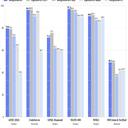

In [31]:
ur.display_base64_image(compressed_image)

In [34]:
prompt_template = """Describe la imagen en detalle. Para el contexto, la siguiente imagen muestra un paper sobre el tema de Deep Learning y desarrollo de modelos de lenguaje.
    Si es una tabla o grafico describe los datos que se presentan en la imagen de manera clara y concisa, rescata los puntos más importantes.

    todo tiene que ser en español
    """

messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

#model_v = OllamaLLM(model="llama3.2-vision:latest")
model_v = OllamaLLM(model="bakllava:latest")

chain = prompt | model_v | StrOutputParser()
# falta re dimensionar las imagenes (repo del banco)
image_summaries = chain.invoke(compressed_image)

KeyboardInterrupt: 

In [33]:
image_summaries

'73,986,495 is the address of the house in the background.'

In [12]:
tables_html_chunks

[{'text_html': '<table><tbody><tr><td>.1</td><td>Contributions|</td><td></td><td>.</td><td>. .</td><td>. .</td><td>.</td><td>...</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>2</td><td>?ummary</td><td>of</td><td></td><td></td><td></td><td>EvaluationResults|.</td><td></td><td></td><td>.</td><td>.</td><td>. .</td><td></td><td>...</td><td></td><td></td><td>...</td><td></td><td>..</td><td></td><td>.</td><td></td><td></td><td></td><td></td><td>oo</td><td></td><td></td></tr><tr><td></td><td>\\pproacE</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>T</td><td>OVEIVIEW].</td><td>«</td><td>o</td><td>o o</td><td>v e</td><td>e</td><td></td><td></td><

In [13]:
images_b64_chunks

[{'images_b64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAV0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iisXxN4hh8O6YZ3Ae4kysEf95vU+w7/AP16unTlUmoQV2xNqKuy5qesWGjwCa/uUhU/dB5ZvoBya468+KNsjFbLTpZR2aVwn6DNeeahqF1ql491eTNLM3c9h6Adh7VVr6nD5JRhG9b3n+BwzxMm/d0

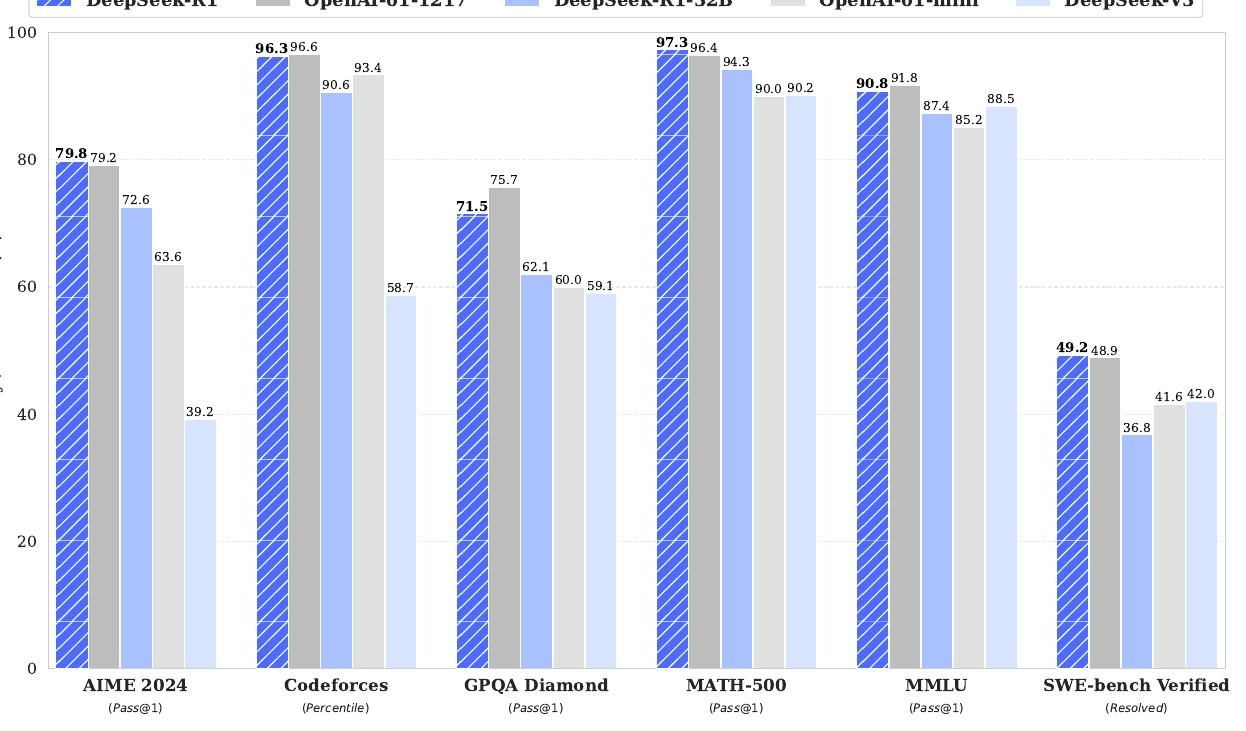

In [14]:
utils_rag.display_base64_image(images_b64_chunks[1]['images_b64'])

In [35]:

from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt_text = """
Eres un asistente cuya tarea es resumir tablas y texto.
Da un resumen conciso de la tabla o el texto.

Responde solo con el resumen, sin comentarios adicionales.
No comiences tu mensaje diciendo "Aquí hay un resumen" ni nada por el estilo.
Solo da el resumen tal como está.

Fragmento de tabla o texto: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.2, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()


In [42]:
def summarize_text_chunks(text_chunks,text):
    """
    Aplica la cadena de resumen a cada fragmento de texto.
    
    Args:
        text_chunks (List[Dict]): Lista de diccionarios con 'text' y 'page_number'.
    
    Returns:
        List[Dict]: Lista de diccionarios con 'summary' y 'page_number'.
    """
    summarized_chunks = []
    
    for chunk in text_chunks:
        texto = chunk[text]
        paginas = chunk['page_number']
        
        # Crear el contexto para el prompt, incluyendo las páginas
        prompt_input = f"{texto}"
        
        # Aplicar la cadena de resumen
        resumen = summarize_chain.invoke(prompt_input)
        
        summarized_chunks.append({
            'summary': resumen,
            'page_number': paginas
        })
    
    return summarized_chunks

# Aplicar la función de resumen
summaries = summarize_text_chunks(text_chunks,'text')

In [ ]:
summaries

In [45]:
summaries_tables = summarize_text_chunks(tables_html_chunks,'text_html')

In [ ]:
summaries_tables

In [ ]:
utils_rag.display_chunk_pages(chunks[7],file_path)

In [ ]:
display(rich_Markdown(text_chunk)) 

In [ ]:
utils_rag.display_chunk_pages(chunks[8],file_path)

In [91]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [92]:

from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt_text = """
Eres un asistente cuya tarea es resumir tablas y texto.
Da un resumen conciso de la tabla o el texto.

Responde solo con el resumen, sin comentarios adicionales.
No comiences tu mensaje diciendo "Aquí hay un resumen" ni nada por el estilo.
Solo da el resumen tal como está.

Fragmento de tabla o texto: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
summarize_chain_2 = prompt | model | StrOutputParser()

In [93]:
table_summaries = summarize_chain.batch(tables_html_chunk, {"max_concurrency": 3})

In [ ]:
table_summaries

In [ ]:

display(rich_Markdown(table_summaries[0]))

In [96]:
resumen = summarize_chain_2.invoke(text_chunk)

In [ ]:
display(rich_Markdown(resumen))

In [ ]:
from IPython.display import Markdown, display_pdf
from rich.markdown import Markdown as rich_Markdown

display(rich_Markdown(texts_1[0].to_dict()['text'])) 

In [ ]:
texts_1[1].metadata.orig_elements[1].to_dict() 

In [ ]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [ ]:
import os
from typing import List, Dict, Any

